# PROJET ML — CLASSIFICATION DE VIDÉOS YOUTUBE *TRENDING*

**Dataset Kaggle**: https://www.kaggle.com/datasets/datasnaek/youtube-new

**Objectif**: Développer un classificateur pour prédire si une vidéo YouTube deviendra *trending*.

> Ce notebook est conçu pour être complété. Chaque section contient des consignes détaillées et des zones de code à compléter.


## 1. Importation des librairies

**Consigne 1.1 — Importez toutes les librairies nécessaires**
- `pandas`, `numpy` pour la manipulation de données  
- `matplotlib.pyplot`, `seaborn` pour la visualisation  
- `sklearn` pour le machine learning  
- `warnings` pour supprimer les avertissements

In [60]:
# VOTRE CODE ICI - Section 1.1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import sys

# Suppression des warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

## 2. Chargement et exploration des données

**Consigne 2.1 — Chargement des données**
- Chargez le fichier `USvideos.csv` avec pandas  
- Affichez les 5 premières lignes  
- Affichez les informations générales (`info()`, `shape`, `describe()`)

*Aide* :
- Utilisez `pd.read_csv()` avec `encoding='utf-8'`
- `.info()` donne les types de colonnes et valeurs non-nulles
- `.describe()` donne les statistiques descriptives

In [ ]:
# VOTRE CODE ICI - Section 2.1
import pandas as pd
df = pd.read_csv('~/youtube-popularity-ml/archive/USvideos.csv', encoding='utf-8')
print("Premières lignes:")
display(df.head(5))
print("\nInformations générales:")
display(df.info())
print("Shape: ....")
display(df.describe(include='all').transpose())

**Consigne 2.2 — Analyse des valeurs manquantes**  
- Comptez les valeurs manquantes par colonne  
- Identifiez les colonnes avec le plus de valeurs manquantes  
- Affichez le pourcentage de valeurs manquantes

In [62]:
# VOTRE CODE ICI - Section 2.2
missing = df.isna().sum()
pct_missing = (missing / len(df)) * 100
missing_nonzero = missing[missing>0]
pct_missing_nonzero = pct_missing[pct_missing>0].round(2)
print("Valeurs manquantes (nombre):")
print(missing_nonzero)
print("\nValeurs manquantes (pourcentage):")
print(pct_missing_nonzero)

Valeurs manquantes (nombre):
description    570
dtype: int64

Valeurs manquantes (pourcentage):
description    1.39
dtype: float64


**Consigne 2.3 — Exploration des catégories**  
- Chargez le fichier JSON des catégories (`US_category_id.json`)  
- Fusionnez avec le DataFrame principal  
- Affichez la distribution des catégories

*Aide* : La structure JSON est du type:  
`{"items": [{"id": "1", "snippet": {"title": "Film & Animation"}}, ...]}`

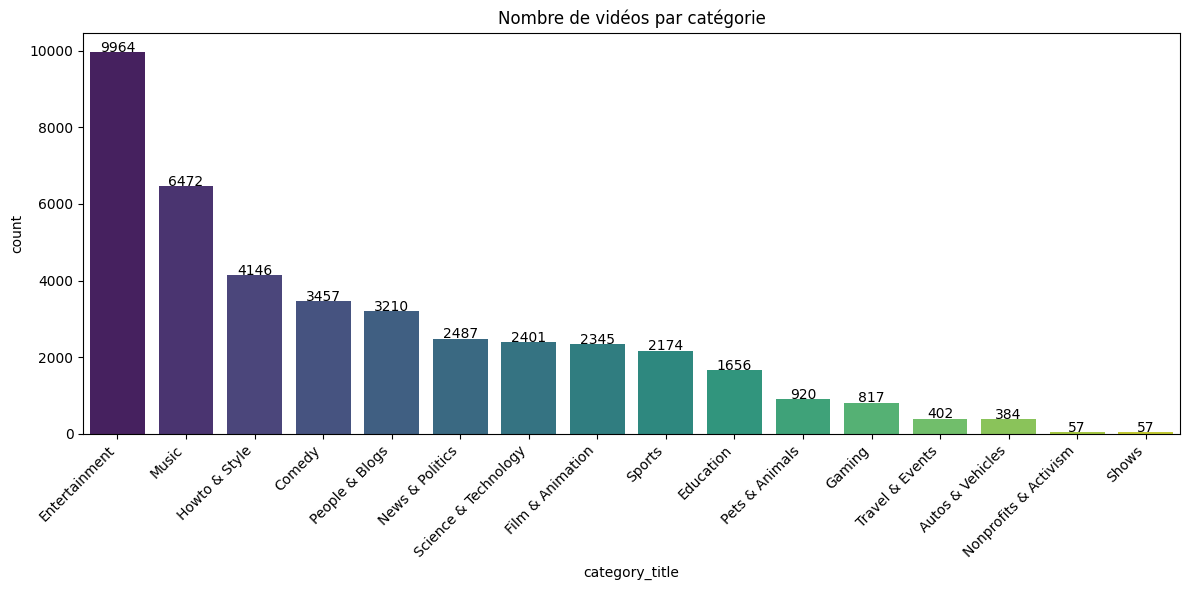

In [63]:
# VOTRE CODE ICI - Section 2.3
import pandas as pd
import json
categories_raw = pd.read_json("~/youtube-popularity-ml/archive/US_category_id.json")
items = categories_raw['items'].tolist()
category_dict = {int(item['id']): item['snippet']['title'] for item in items}
cat_df = pd.DataFrame(list(category_dict.items()), columns=['category_id', 'category_title'])
df_merged = df.merge(cat_df, how='left', left_on='category_id', right_on='category_id')
# print("Distribution des catégories:")
# display(df_merged['category_title'].value_counts().to_frame('count'))
#Nombre de vidéos par catégorie visualisation
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df_merged, x='category_title', palette='viridis',
                   order=df_merged['category_title'].value_counts().index)
plt.xticks(rotation=45, ha='right') 
plt.title("Nombre de vidéos par catégorie")
plt.tight_layout()

# Ajouter des chiffres au-dessus des colonnes
for p in ax.patches:
    height = p.get_height()  # hauteur de la colonne
    ax.text(p.get_x() + p.get_width()/2., height + 5,# 5 — retrait en haut
            f'{int(height)}', ha="center")  # centrage sur X

plt.show()


## 3. Nettoyage des données

**Consigne 3.1 — Nettoyage des données**
- Supprimez les doublons basés sur `video_id`  
- Gérez les valeurs manquantes dans `description` (remplacez par string vide)  
- Convertissez `publish_time` en datetime  
- Supprimez les lignes avec des valeurs aberrantes (ex: `views` négatives)

In [64]:
# VOTRE CODE ICI - Section 3.1
df_clean = df.drop_duplicates(subset='video_id').copy()
df_clean['description'] = df_clean["description"].fillna("Unknown")
# display(df_clean.isna().sum()) missing values 0
import pandas as pd
df_clean['publish_time'] = pd.to_datetime(df_clean["publish_time"], errors='coerce')
# on a supprimé les lignes avec des valeurs aberrantes
df_clean = df_clean[(df_clean['views'] >= 0) & (df_clean['likes'] >= 0) & (df_clean['dislikes'] >= 0) & (df_clean['comment_count'] >= 0)]
df_clean = df_clean.dropna(subset=['publish_time'])
display(df_clean['publish_time'].dtype)

datetime64[ns, UTC]

## 4. Feature Engineering

**Consigne 4.1 — Variables d'engagement**
** définition : https://support.google.com/youtube/answer/2991785?hl=fr**

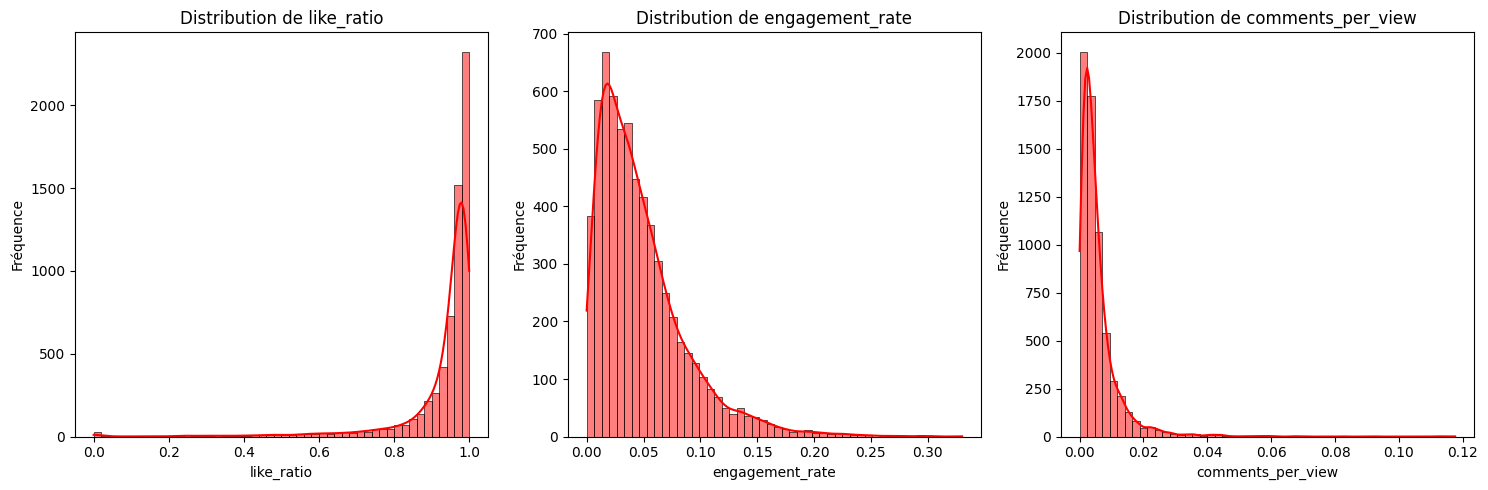

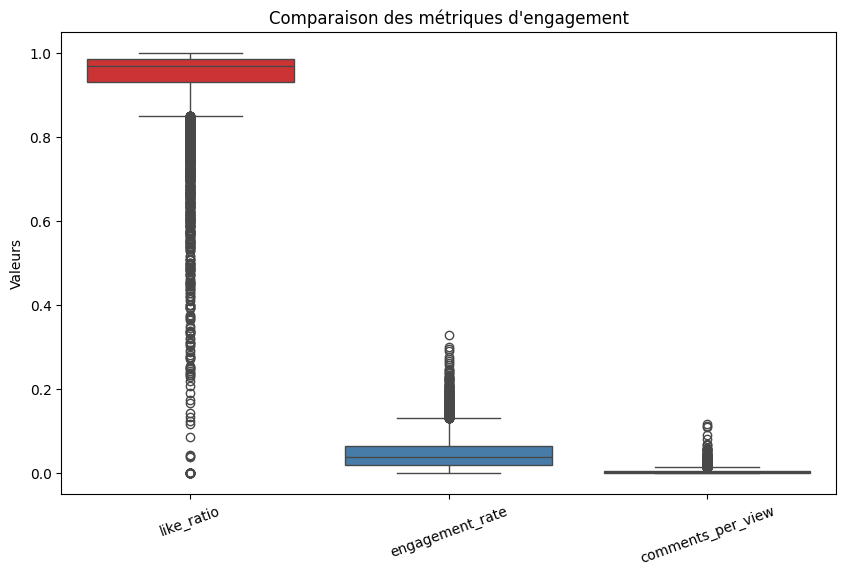

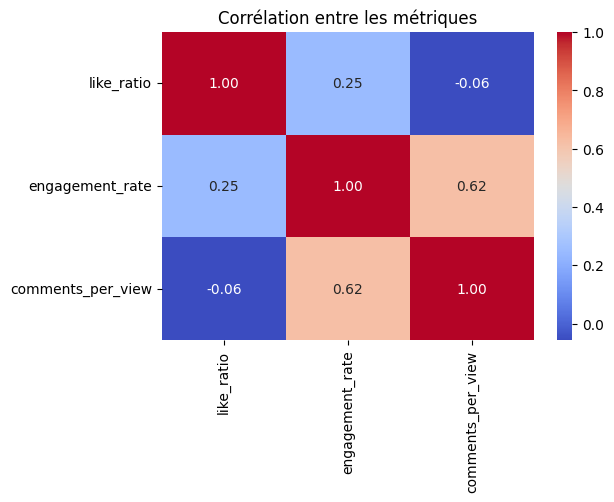

In [65]:
# VOTRE CODE ICI - Section 4.1
import numpy as np
eps = 1e-9  # eps protège contre la division par zéro
denom = df_clean['likes'] + df_clean['dislikes']
df_clean['like_ratio'] = np.where(denom > 0, df_clean['likes'] / denom, 0)
df_clean['engagement_rate'] = np.where(df_clean['views'] > 0,
                                       (df_clean['likes'] + df_clean['dislikes'] + df_clean['comment_count']) / (df_clean['views'] + eps),
                                       0)
df_clean['comments_per_view'] = np.where(df_clean['views'] > 0, df_clean['comment_count'] / (df_clean['views'] + eps), 0)
# display(df_clean['comments_per_view'], df_clean['engagement_rate'])

import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes à analyser
metriques = ['like_ratio', 'engagement_rate', 'comments_per_view']

# 1. Histogrammes pour chaque métrique
plt.figure(figsize=(15,5))

for i, metrique in enumerate(metriques, 1):
    plt.subplot(1, 3, i)  # 1 ligne, 3 colonnes, i = position
    sns.histplot(df_clean[metrique], bins=50, kde=True, color='red')
    plt.title(f"Distribution de {metrique}")
    plt.xlabel(metrique)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

# 2. Boxplot pour comparer les métriques
plt.figure(figsize=(10,6))
sns.boxplot(data=df_clean[metriques], palette='Set1')
plt.title("Comparaison des métriques d'engagement")
plt.ylabel("Valeurs")
plt.xticks(rotation=20)
plt.show()

# 3. Carte de chaleur (corrélation entre les métriques)
plt.figure(figsize=(6,4))
sns.heatmap(df_clean[metriques].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les métriques")
plt.show()



## 1. Engagement rate proche de 0
- Les **likes, dislikes et commentaires** représentent une toute petite proportion du **nombre total de vues**.  
- Les spectateurs regardent principalement les vidéos, mais **réagissent très peu** (peu de likes ou de commentaires).  
- Typique pour les grandes chaînes : des millions de vues mais beaucoup moins de réactions.

## 2. Comments per view proche de 0
- Très peu de spectateurs laissent un commentaire.  
- Normal : seul un **petit pourcentage** commente réellement.

## 4. Remarques générales
- Le nombre de commentaires influence davantage l’engagement que les likes ou dislikes.

- Sur la plupart des vidéos, il y a des likes, mais presque pas de dislikes.

- L’engagement global **(commentaires + likes + dislikes)** est faible, car beaucoup de vues mais peu de réactions.

**Consigne 4.2 — Variables temporelles**

In [ ]:
# VOTRE CODE ICI - Section 4.2
df_clean['publish_hour'] = df_clean['publish_time'].dt.hour
display(df_clean['publish_hour'])
df_clean['publish_day_of_week'] = df_clean['publish_time'].dt.day
display(df_clean['publish_day_of_week'])
df_clean['publish_month'] = df_clean['publish_time'].dt.month
display(df_clean['publish_month'])

**Consigne 4.3 — Variables textuelles (titre)**

In [ ]:
# VOTRE CODE ICI - Section 4.3
df_clean['title_length'] = df_clean['title'].str.strip().str.len()
display(df_clean['title_length'])
df_clean['title_word_count'] = df_clean['title'].str.rsplit().str.len()
display(df_clean['title_word_count'])
df_clean['has_caps'] = df_clean['title'].str.contains(r'[A-Z]')
display(df_clean['has_caps'])
df_clean['has_numbers'] = df_clean['title'].str.contains(r'[0-9]')
display(df_clean['has_numbers'])

## 5. Création de la variable cible

**Consigne 5.1 — Définition de `is_trending`**  
- Une vidéo est *trending* si elle a plus de vues que le 80e percentile de sa catégorie

Distribution de la variable cible:


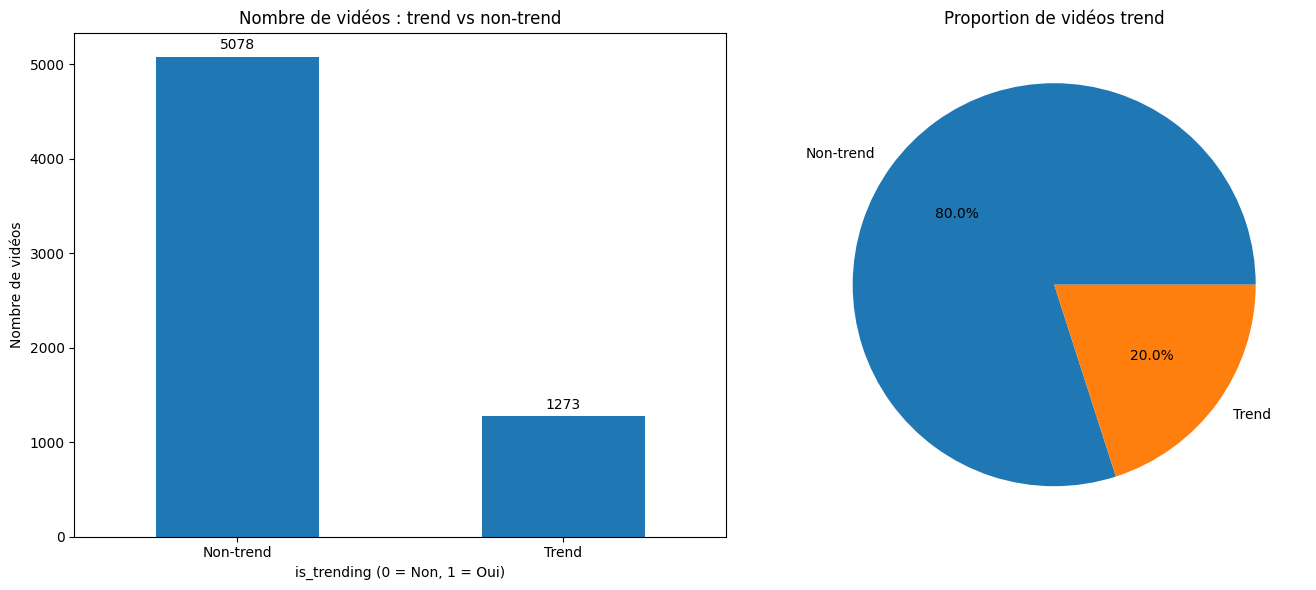

In [68]:
# VOTRE CODE ICI - Section 5.1
import matplotlib.pyplot as plt

df_clean['is_trending'] = (df_clean.groupby('category_id')['views']
                                  .transform(lambda x: x > x.quantile(0.8))).astype(int)
print("Distribution de la variable cible:")
# print(df_clean['is_trending'].value_counts().to_frame('count'))

# Compter le nombre de vidéos non-trend (0) et trend (1)
counts = df_clean['is_trending'].value_counts().sort_index()

plt.figure(figsize=(14,6))

# 1. Diagramme en barres : nombre de vidéos trend vs non-trend
plt.subplot(1, 2, 1)
counts.plot(kind='bar')
plt.title("Nombre de vidéos : trend vs non-trend")
plt.xlabel("is_trending (0 = Non, 1 = Oui)")
plt.ylabel("Nombre de vidéos")
plt.xticks([0,1], ['Non-trend', 'Trend'], rotation=0)  # Noms des catégories

# Ajouter des légendes avec des chiffres aux colonnes
for i, v in enumerate(counts):
    plt.text(i, v + counts.max()*0.01, str(v), ha='center', va='bottom', fontsize=10)


# 2. Diagramme circulaire : proportion de vidéos trend vs non-trend
plt.subplot(1, 2, 2)
counts.plot(kind='pie', autopct='%1.1f%%', labels=['Non-trend','Trend'])
plt.title("Proportion de vidéos trend")
plt.ylabel("")  # On enlève le label Y pour un look plus propre

plt.tight_layout()
plt.show()


## 6. Préparation des données pour l'entraînement

**Consignes 6.1 & 6.2 — Sélection des features & split train/test**

In [69]:
# VOTRE CODE ICI - Section 6.1 et 6.2
features = ['views', 'likes', 'dislikes', 'comment_count',
            'like_ratio', 'engagement_rate', 'title_length', 'publish_hour', 'category_id']
X = df_clean[features].copy() #features
y = df_clean['is_trending'].copy() #target 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cfi = svm.SVC()
cfi.fit(X_train, y_train)

predict = cfi.predict(X_test)

acc = accuracy_score(y_test, predict)
print(f"Accuracy: {acc:.4f}")
clasr = classification_report(y_test, predict)
print(clasr)
print(f"Taille train: {X_train.shape}")
print(f"Taille test: {X_test.shape}")

Accuracy: 0.9355
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1001
           1       0.94      0.74      0.83       270

    accuracy                           0.94      1271
   macro avg       0.94      0.86      0.90      1271
weighted avg       0.94      0.94      0.93      1271

Taille train: (5080, 9)
Taille test: (1271, 9)


**Consigne 6.3 — Normalisation des données (StandardScaler)**

In [91]:
# VOTRE CODE ICI - Section 6.3
scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features]) 
# Fit uniquement sur train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cfi = svm.SVC()
cfi.fit(X_train, y_train)

predict = cfi.predict(X_test)

acc = accuracy_score(y_test, predict)
print(f"Accuracy: {acc:.4f}")
clasr = classification_report(y_test, predict)
print(clasr)
print(f"Taille train: {X_train.shape}")
print(f"Taille test: {X_test.shape}")
print(X[features].head(3))

Accuracy: 0.9355
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1001
           1       0.94      0.74      0.83       270

    accuracy                           0.94      1271
   macro avg       0.94      0.86      0.90      1271
weighted avg       0.94      0.94      0.93      1271

Taille train: (5080, 9)
Taille test: (1271, 9)
     views   likes  dislikes  comment_count  like_ratio  engagement_rate  \
0   748374   57527      2966          15954    0.950970         0.102151   
1  2418783   97185      6146          12703    0.940521         0.047972   
2  3191434  146033      5339           8181    0.964729         0.049994   

   title_length  publish_hour  category_id  
0            34            17           22  
1            62             7           24  
2            53            19           23  


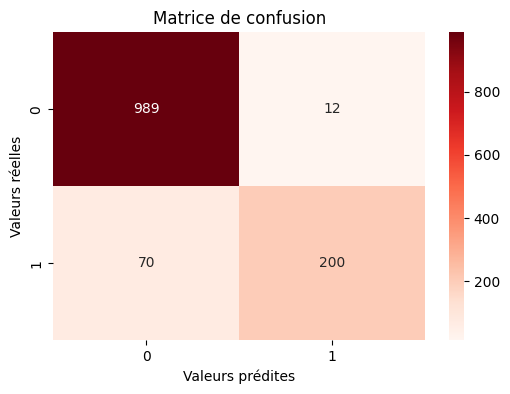

In [71]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize=(6,4))
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Reds')
plt.ylabel('Valeurs réelles')
plt.xlabel('Valeurs prédites')
plt.title('Matrice de confusion')
plt.show()

## 7. Modèle 1 — Random Forest

**Consigne 7.1 — Entraînement**

In [72]:
# VOTRE CODE ICI - Section 7.1
from sklearn.ensemble import RandomForestClassifier

# Modèle
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
# Prédictions sur le test set
rf_predictions = rf_model.predict(X_test)


**Consigne 7.2 — Évaluation**

Random Forest - Résultats:
Accuracy: 0.9693
Precision: 0.9602
Classification report:               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1001
           1       0.96      0.89      0.93       270

    accuracy                           0.97      1271
   macro avg       0.97      0.94      0.95      1271
weighted avg       0.97      0.97      0.97      1271

Recall: 0.8926
F1-Score: 0.9251

Top 10 variables importantes:


views              0.483721
likes              0.108334
dislikes           0.127493
comment_count      0.095565
like_ratio         0.021011
engagement_rate    0.051869
title_length       0.015687
publish_hour       0.015425
category_id        0.080894
dtype: float64

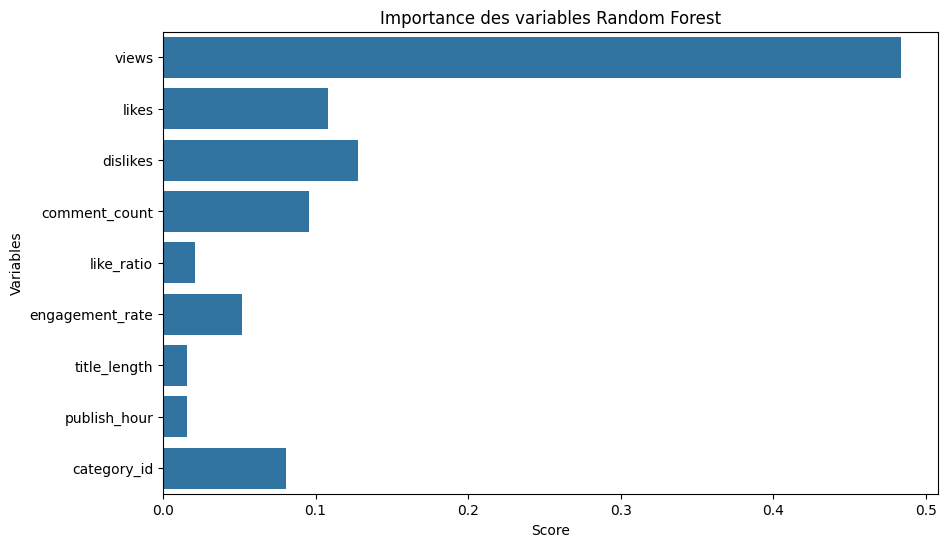

In [73]:
# VOTRE CODE ICI - Section 7.2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Random Forest - Résultats:")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Precision: {precision_score(y_test, rf_predictions):.4f}")
print(f"Classification report: {classification_report(y_test, rf_predictions)}")
print(f"Recall: {recall_score(y_test, rf_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_predictions):.4f}")
# Importance des variables
import pandas as pd
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns)
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf_model.feature_importances_
# }).sort_values('importance', ascending=False)
print("\nTop 10 variables importantes:")
display(feature_importance.head(10))

# Visualisation de l'importance de variables

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance,
            y=feature_importance.index)
plt.title('Importance des variables Random Forest')
plt.xlabel('Score')
plt.ylabel('Variables')
plt.show()

## 8. Modèle 2 — Support Vector Machine (SVM)

**Consigne 8.1 — Entraînement (utiliser données normalisées)**

In [74]:
# VOTRE CODE ICI - Section 8.1
from sklearn.svm import SVC
#Regardez la consigne 6.3

**Consigne 8.2 — Évaluation**

In [75]:
# VOTRE CODE ICI - Section 8.2
# print("SVM - Résultats:")
# print(f"Accuracy: {accuracy_score(y_test, svm_predictions):.4f}")
#Regardez la consigne 6.3

## 9. Modèle 3 — Gradient Boosting (XGBoost)

**Consigne 9.1 — Entraînement**

In [76]:
# VOTRE CODE ICI - Section 9.1
try:
    from xgboost import XGBClassifier
    xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42, n_jobs=-1, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
except ImportError:
    print("XGBoost n'est pas installé. Installez avec: pip install xgboost")
    xgb_model = None
    xgb_predictions = None

**Consigne 9.2 — Évaluation**

In [77]:
# VOTRE CODE ICI - Section 9.2
if xgb_predictions is not None:
    print("XGBoost - Résultats:")
    print(f"Accuracy: {accuracy_score(y_test, xgb_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, xgb_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, xgb_predictions):.4f}")
    print(f"F1-Score: {f1_score(y_test, xgb_predictions):.4f}")

XGBoost - Résultats:
Accuracy: 0.9921
Precision: 0.9924
Recall: 0.9704
F1-Score: 0.9813


## 10. Modèle 4 — Réseau de Neurones (MLPClassifier)

**Consigne 10.1 — Entraînement (données normalisées)**

In [78]:
# VOTRE CODE ICI - Section 10.1
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), alpha=0.01, activation='relu', solver='adam', max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_predictions = nn_model.predict(X_test_scaled)

**Consigne 10.2 — Évaluation**

Réseau de Neurones - Résultats:
Precision: 0.9585
Recall: 0.8556
F1-Score: 0.9041
Iterations: 189


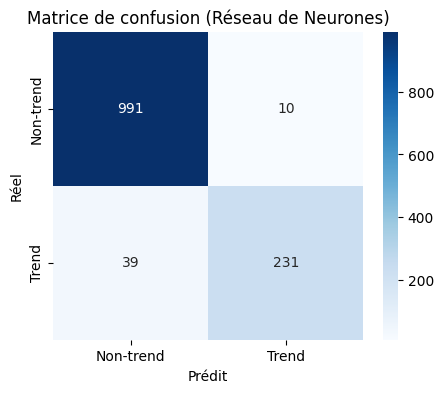

In [79]:
# VOTRE CODE ICI - Section 10.2
print("Réseau de Neurones - Résultats:")

print(f"Precision: {precision_score(y_test, nn_predictions):.4f}")
print(f"Recall: {recall_score(y_test, nn_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, nn_predictions):.4f}")
# # Nombre d'itérations
print(f"Iterations: {nn_model.n_iter_}")

report_dict = classification_report(y_test, nn_predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

cm = confusion_matrix(y_test, nn_predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-trend", "Trend"], yticklabels=["Non-trend", "Trend"])
plt.title("Matrice de confusion (Réseau de Neurones)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

## 11. Comparaison des modèles

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.969315,0.960159,0.892593,0.925144
1,SVM,0.935484,0.943396,0.740741,0.829876
2,XGBoost,0.992132,0.992424,0.970370,0.981273
3,Neural Network,0.961448,0.958506,0.855556,0.904110


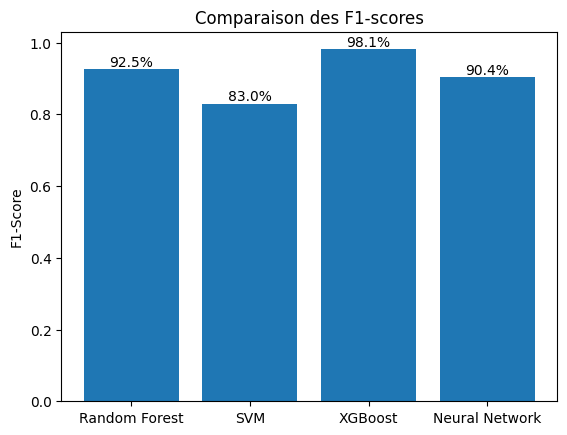

In [80]:
# VOTRE CODE ICI - Section 11.1
import pandas as pd
results = []
# Remplir en fonction des métriques calculées plus haut
results.append({'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, rf_predictions), 'Precision': precision_score(y_test, rf_predictions), 'Recall': recall_score(y_test, rf_predictions), 'F1-Score': f1_score(y_test, rf_predictions)})
results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': precision_score(y_test, predict), 'Recall': recall_score(y_test, predict), 'F1-Score': f1_score(y_test, predict)})
if xgb_predictions is not None: results.append({'Model': 'XGBoost', 'Accuracy': accuracy_score(y_test, xgb_predictions), 'Precision': precision_score(y_test, xgb_predictions), 'Recall': recall_score(y_test, xgb_predictions), 'F1-Score': f1_score(y_test, xgb_predictions)})
results.append({'Model': 'Neural Network', 'Accuracy': accuracy_score(y_test, nn_predictions), 'Precision': precision_score(y_test, nn_predictions), 'Recall': recall_score(y_test, nn_predictions), 'F1-Score': f1_score(y_test, nn_predictions)})
results_df = pd.DataFrame(results)
display(results_df)
# Graphique comparatif des F1-scores (optionnel)
import matplotlib.pyplot as plt
plt.figure()
bars = plt.bar(results_df['Model'], results_df['F1-Score'])
# Affichage % 
plt.bar_label(bars, labels=[f'{v*100:.1f}%' for v in results_df['F1-Score']])
plt.title('Comparaison des F1-scores')
plt.ylabel('F1-Score')
plt.show()

## 12. Validation croisée

In [ ]:
# VOTRE CODE ICI - Section 12.1
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources") # for hide warnings 
# Exemple avec Random Forest (remplacez par votre meilleur modèle)
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"Validation croisée RF- F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
scores = cross_val_score(cfi, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"Validation croisée SVM - F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"Validation croisée XGB - F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
scores = cross_val_score(nn_model, X_train_scaled, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"Validation croisée MLP - F1-Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Validation croisée RF- F1-Score: 0.9330 (+/- 0.0255)
Validation croisée SVM - F1-Score: 0.8323 (+/- 0.0385)
Validation croisée XGB - F1-Score: 0.9774 (+/- 0.0155)
Validation croisée MLP - F1-Score: 0.9070 (+/- 0.0121)


## 13. Optimisation des hyperparamètres (Grid Search)

In [82]:
# VOTRE CODE ICI - Section 13.1
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score CV:", grid_search.best_score_)
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)

Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score CV: 0.9310711755108757


## 14. Analyse des erreurs

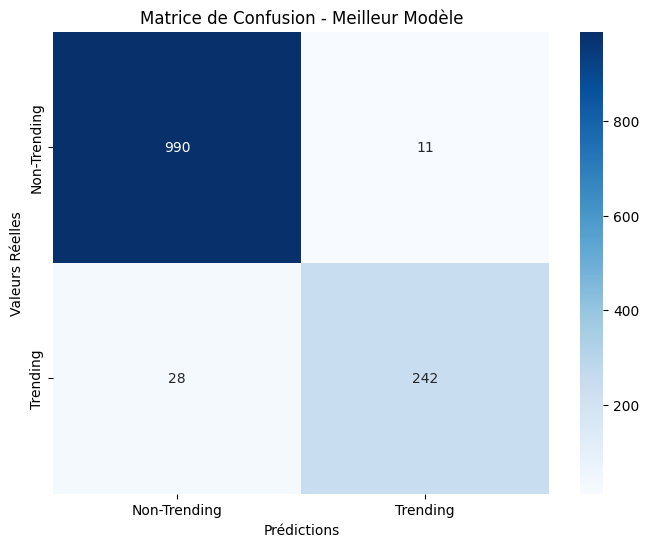

In [83]:
# VOTRE CODE ICI - Section 14.1
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Exemple: matrice de confusion pour le meilleur modèle (remplacez best_rf_pred)
cm = confusion_matrix(y_test, best_rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Trending', 'Trending'],
            yticklabels=['Non-Trending', 'Trending'])
plt.title('Matrice de Confusion - Meilleur Modèle')
plt.ylabel('Valeurs Réelles')
plt.xlabel('Prédictions')
plt.show()

In [84]:
# Random Forest
errors_mask = (y_test != best_rf_pred)
error_indices = X_test[errors_mask].index
print("Exemples de vidéos mal classifiées (Random Forest):\n")
for idx in list(error_indices)[:5]:
    real_label = y_test.loc[idx]
    predicted_label = best_rf_pred[y_test.index.get_loc(idx)]
    print(f"Index {idx}: Réel={real_label}, Prédit={predicted_label}")

# Support Vector Machine
errors_mask = (y_test != predict)
error_indices = X_test[errors_mask].index
print("\nExemples de vidéos mal classifiées (Support Vector Machine):\n")
for idx in list(error_indices)[:5]:
    real_label = y_test.loc[idx]
    predicted_label = predict[y_test.index.get_loc(idx)]
    print(f"Index {idx}: Réel={real_label}, Prédit={predicted_label}")

# Gradient Boosting
errors_mask = (y_test != xgb_predictions)
error_indices = X_test[errors_mask].index
print("\nExemples de vidéos mal classifiées (Gradient Boosting):\n")
for idx in list(error_indices)[:5]:
    real_label = y_test.loc[idx]
    predicted_label = xgb_predictions[y_test.index.get_loc(idx)]
    print(f"Index {idx}: Réel={real_label}, Prédit={predicted_label}")

# MLP Classifier
errors_mask = (y_test != nn_predictions)
error_indices = X_test[errors_mask].index
print("\nExemples de vidéos mal classifiées (MLP Classifier):\n")
for idx in list(error_indices)[:5]:
    real_label = y_test.loc[idx]
    predicted_label = nn_predictions[y_test.index.get_loc(idx)]
    print(f"Index {idx}: Réel={real_label}, Prédit={predicted_label}")

Exemples de vidéos mal classifiées (Random Forest):

Index 27578: Réel=1, Prédit=0
Index 31781: Réel=0, Prédit=1
Index 22565: Réel=0, Prédit=1
Index 36752: Réel=1, Prédit=0
Index 30360: Réel=1, Prédit=0

Exemples de vidéos mal classifiées (Support Vector Machine):

Index 27578: Réel=1, Prédit=0
Index 35155: Réel=1, Prédit=0
Index 22565: Réel=0, Prédit=1
Index 14009: Réel=1, Prédit=0
Index 10347: Réel=0, Prédit=1

Exemples de vidéos mal classifiées (Gradient Boosting):

Index 257: Réel=0, Prédit=1
Index 36752: Réel=1, Prédit=0
Index 20974: Réel=1, Prédit=0
Index 6807: Réel=1, Prédit=0
Index 16598: Réel=1, Prédit=0

Exemples de vidéos mal classifiées (MLP Classifier):

Index 27578: Réel=1, Prédit=0
Index 31781: Réel=0, Prédit=1
Index 14009: Réel=1, Prédit=0
Index 36752: Réel=1, Prédit=0
Index 30360: Réel=1, Prédit=0


## 15. Sauvegarde & conclusions

In [85]:
# VOTRE CODE ICI - Section 15.1
import joblib
import os

# Extension ~ vers le chemin d'accès au répertoire personnel
path_model = os.path.expanduser('~/youtube-popularity-ml/model/best_youtube_classifier.pkl')
path_scaler = os.path.expanduser('~/youtube-popularity-ml/model/feature_scaler.pkl')

# Remplacez 'best_rf' / 'scaler' par vos objets
joblib.dump(xgb_model, path_model)
joblib.dump(scaler, path_scaler)
print("Modèle et scaler sauvegardés avec succès!")

Modèle et scaler sauvegardés avec succès!


### Conclusions à rédiger

1. **Meilleur modèle**  
   - Modèle: *XGBoost*  
   - Performances: *XGBoost: F1-Score: 0.9774 (+/- 0.0155)*  
   - Raisons: *[À compléter]*

2. **Variables les plus importantes**  
   - Top 10:
   - *Views*
   - *Dislikes*
   - *Likes*
   - *comment_count*
   - *category_id*
   - *engagement_rate*
   - *like_ratio*
   - *title_length*
   - *publish_hour*

3. **Limitations**  
   - *Facteurs qualitatifs non inclus, dataset déséquilibré, Neural Network sensible à l’échelle.*

4. **Améliorations suggérées**  
   - *Features temporelles, tuning hyperparamètres*

5. **Apprentissages**  
   - *importance du scaling, cross-validation pour métriques fiables, puissance du boosting, compréhension de F1, Precision et Recall.*

---
## Guide de testing pour les étudiants

**Comment tester vos implémentations :**
1. **Vérifications de base** : `.shape`, `.info()`, `.head()`  
2. **Validation des features** : pas de NaN, ratios entre 0 et 1, plages temporelles correctes  
3. **Validation des modèles** : prédictions binaires {0,1}, longueurs cohérentes, comparaisons rigoureuses  
4. **Tests de cohérence** : scores réalistes, F1 entre précision et rappel, impact de la normalisation  
5. **Debugging** : augmenter `max_iter` si nécessaire, vérifier entrées/sorties et dimensions